In [11]:
# libraries
RANDOM_STATE = 233

# basic analysis & viz
import numpy as np
np.random.seed(RANDOM_STATE)

import pandas as pd
import seaborn as sns
import missingno as msn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# plt.style.use('ggplot')
sns.set_style('darkgrid', {'grid.background': 'blue'})

# statistics
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy.stats as stats

# from sklearn.datasets import load_boston
# from fairlearn.datasets import fetch_boston

# split & metrics
from sklearn.model_selection import (
    cross_validate, cross_val_score,
    GridSearchCV, KFold, RandomizedSearchCV, 
    train_test_split, StratifiedKFold 
)
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    mean_absolute_percentage_error, make_scorer,
    root_mean_squared_error, PredictionErrorDisplay
)
from sklearn.metrics._scorer import _SCORERS

# preprocessing
# import smogn
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.preprocessing import (
    OneHotEncoder, KBinsDiscretizer, MinMaxScaler,
    OrdinalEncoder, RobustScaler, StandardScaler,
    PolynomialFeatures, 
)
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import RFE, RFECV

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from category_encoders import BinaryEncoder

# models
import shap
shap.initjs()

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.linear_model import (
    LinearRegression, Lasso, Ridge,
    HuberRegressor, TheilSenRegressor,
    QuantileRegressor, RANSACRegressor
)

from sklearn.ensemble import (
    AdaBoostRegressor, GradientBoostingRegressor,
    VotingRegressor, RandomForestRegressor
)
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm import LGBMRegressor

# others
import os
import sys
import time
import pickle
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [12]:
df_all = pd.read_csv(r'C:\Users\ivans\Desktop\FINAL PROJECT\Dataset\AutoInsurance.csv')
df_all.head(5)

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,Married,69,32,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,Single,94,13,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,Suburban,Married,108,18,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize
3,WW63253,California,7645.861827,No,Basic,Bachelor,1/20/11,Unemployed,M,0,Suburban,Married,106,18,65,0,7,Corporate Auto,Corporate L2,Offer1,Call Center,529.881344,SUV,Medsize
4,HB64268,Washington,2813.692575,No,Basic,Bachelor,3/2/2011,Employed,M,43836,Rural,Single,73,12,44,0,1,Personal Auto,Personal L1,Offer1,Agent,138.130879,Four-Door Car,Medsize


# SPLIT DATASET FOR DATATEST

In [13]:
# Features and target variable
X = df_all.drop(columns=['Customer Lifetime Value'])
y = df_all['Customer Lifetime Value']

# Split the data without stratification (since 'Customer Lifetime Value' is continuous)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine the training and test sets with the target variable
df = X_train.copy()
df['Customer Lifetime Value'] = y_train

test_data = X_test.copy()
test_data['Customer Lifetime Value'] = y_test

# Save the test set to a CSV file
test_data.to_csv('test_data_finpro.csv', index=False)

print("Test data saved to 'test_data_finpro.csv'")
print("Shape of the training data:", df.shape)
print("Shape of the real test set data:", test_data.shape)

Test data saved to 'test_data_finpro.csv'
Shape of the training data: (7307, 24)
Shape of the real test set data: (1827, 24)


## DATA CLEANING & HANDLING THE ANOMALY

## Check data type, nullity, negative value, multiple whitespace, number of unique

In [14]:
multiple_spaces = [
    any(pd.Series(df[col]).astype(str).str.contains(r'\s{2,}', regex=True)) 
    for col in df.columns
]

# Create the summary DataFrame
summary_df = pd.DataFrame({
    'feature': df.columns.values,
    'data_type': df.dtypes.values,
    'null': df.isna().mean().values * 100,
    'negative': [True if df[col].dtype in [np.int64, np.float64] and (df[col] < 0).any() else False for col in df.columns],
    'multiple_spaces': multiple_spaces,
    'n_unique': df.nunique().values,
    'sample_unique': [df[col].unique() for col in df.columns]
    
})

# Display the summary DataFrame
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
summary_df

,feature,data_type,null,negative,multiple_spaces,n_unique,sample_unique
0,Customer,object,0.0,False,False,7307,"[YQ79307, CY49953, XN16891, EP64069, IW77519, SI88726, NL59519, WW63253, WM64930, KZ95954, CA70404, GN76399, KC11055, LD26428, EI17022, UQ41461, TN79733, UR42360, PM63319, LN62857, MU64306, LR37068, HV75193, FX67699, FG31425, VO29645, LG45849, ZQ22116, PY70169, IB87349, WE80653, XG44587, DC46685, UI73924, FI93397, MC48570, LJ20215, JA34909, HG83893, LZ84227, UD31660, VE47660, KU88219, YY63521, AZ62651, CF95802, RA87395, KN13494, GY88677, SA91515, YN69214, LF94873, UR40795, ED29955, OQ99704, BG30513, DP23630, AT52647, IW21434, JK74110, AS78838, VH43367, FC59209, ML38237, UT76436, GD17919, MR84659, LD20926, QH62059, FR81224, BN38134, LD22387, ED90879, WE64781, KJ72146, CO91673, KY33386, OE19653, IJ33473, OU78642, YE45848, XB77333, MU79385, No34698, LC12930, IV54766, TN29644, EP18940, CY18875, BO81145, PU18983, KC69320, VB23257, ZW32080, ZR88383, FX55923, EZ85603, IJ98317, ZF84449, FJ31683, ...]"
1,State,object,0.0,False,False,5,"[Washington, Oregon, Arizona, California, Nevada]"
2,Response,object,0.0,False,False,2,"[No, Yes]"
3,Coverage,object,0.0,False,False,3,"[Basic, Extended, Premium]"
4,Education,object,0.0,False,False,5,"[Bachelor, College, High School or Below, Master, Doctor]"
5,Effective To Date,object,0.0,False,False,59,"[10/1/2011, 2/18/11, 2/28/11, 8/1/2011, 1/18/11, 1/19/11, 2/14/11, 1/20/11, 8/2/2011, 2/2/2011, 4/2/2011, 6/2/2011, 1/24/11, 5/2/2011, 1/27/11, 1/17/11, 2/22/11, 7/2/2011, 2/21/11, 2/26/11, 1/16/11, 2/24/11, 2/25/11, 3/2/2011, 1/31/11, 1/26/11, 2/1/2011, 1/23/11, 11/2/2011, 1/13/11, 2/19/11, 2/17/11, 10/2/2011, 1/29/11, 1/28/11, 1/14/11, 2/23/11, 5/1/2011, 1/15/11, 1/2/2011, 12/2/2011, 9/2/2011, 9/1/2011, 7/1/2011, 2/27/11, 11/1/2011, 2/20/11, 1/1/2011, 6/1/2011, 4/1/2011, 1/22/11, 1/30/11, 2/15/11, 1/25/11, 2/16/11, 1/21/11, 3/1/2011, 2/13/11, 12/1/2011]"
6,EmploymentStatus,object,0.0,False,False,5,"[Employed, Unemployed, Medical Leave, Retired, Disabled]"
7,Gender,object,0.0,False,False,2,"[M, F]"
8,Income,int64,0.0,False,False,4652,"[51144, 0, 81097, 72264, 54737, 38898, 64642, 12811, 62455, 39411, 14973, 27538, 35095, 23749, 57074, 35773, 26924, 37811, 12430, 27985, 73102, 93011, 70340, 88997, 25370, 55257, 18661, 17576, 59183, 95715, 70129, 30004, 25816, 20396, 56855, 97131, 46268, 27849, 61542, 52801, 13663, 44940, 98333, 29735, 61402, 55910, 35482, 89205, 39428, 53078, 20757, 93836, 30895, 29031, 81568, 87421, 60944, 80055, 22705, 67018, 21723, 21450, 28582, 47590, 37803, 55350, 50405, 86448, 43793, 22828, 53093, 39161, 23170, 66676, 20836, 24702, 26129, 12940, 14072, 39035, 23706, 99816, 14616, 19030, 27978, 33252, 28559, 29462, 71176, 44988, 41154, 60909, 73054, 59853, 28919, 83208, 21189, 31177, 23665, 91193, ...]"
9,Location Code,object,0.0,False,False,3,"[Urban, Suburban, Rural]"


- Data type               : Effective to date should be in datetime type not in object, we should change it
- null                    : There is no null value
- negative                : There is no negative value
- multiple whitespaces    : There is no multiple whitespaces
- unique                  : Customer observation has totally unique we should drop it 

### Handling Datatype

In [15]:
df['Effective To Date'] = pd.to_datetime(df['Effective To Date'],errors='coerce')
df.dtypes

Customer                                 object
State                                    object
Response                                 object
Coverage                                 object
Education                                object
Effective To Date                datetime64[ns]
EmploymentStatus                         object
Gender                                   object
Income                                    int64
Location Code                            object
Marital Status                           object
Monthly Premium Auto                      int64
Months Since Last Claim                   int64
Months Since Policy Inception             int64
Number of Open Complaints                 int64
Number of Policies                        int64
Policy Type                              object
Policy                                   object
Renew Offer Type                         object
Sales Channel                            object
Total Claim Amount                      

### Handling Inappropriate Columns

In [16]:
df = df.drop(columns='Customer')

Because Customer has totally unique value so we need to remove it

## Check Duplicate

In [17]:
df.duplicated().sum()

103

In [18]:
df[df.duplicated(keep=False)].sort_values(by ='Customer Lifetime Value')

,State,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,Marital Status,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size,Customer Lifetime Value
7135,Oregon,Yes,Basic,College,NaT,Unemployed,F,0,Suburban,Divorced,66,16,35,4,1,Personal Auto,Personal L3,Offer1,Branch,316.800000,Four-Door Car,Small,2004.350666
3665,Oregon,Yes,Basic,College,NaT,Unemployed,F,0,Suburban,Divorced,66,16,35,4,1,Personal Auto,Personal L3,Offer1,Branch,316.800000,Four-Door Car,Small,2004.350666
5167,Nevada,Yes,Basic,Bachelor,2011-11-01,Disabled,F,19864,Suburban,Divorced,63,22,96,0,1,Personal Auto,Personal L3,Offer1,Web,352.394515,Four-Door Car,Medsize,2359.423599
6414,Nevada,Yes,Basic,Bachelor,2011-11-01,Disabled,F,19864,Suburban,Divorced,63,22,96,0,1,Personal Auto,Personal L3,Offer1,Web,352.394515,Four-Door Car,Medsize,2359.423599
4935,Oregon,Yes,Basic,Doctor,NaT,Disabled,F,21986,Suburban,Divorced,63,1,9,0,1,Personal Auto,Personal L3,Offer2,Branch,333.696228,Two-Door Car,Medsize,2395.570000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7263,California,Yes,Extended,College,2011-01-02,Retired,F,13663,Suburban,Single,97,1,66,0,2,Personal Auto,Personal L2,Offer1,Branch,465.600000,Four-Door Car,Small,25464.820590
698,Arizona,Yes,Extended,Bachelor,NaT,Employed,F,33806,Urban,Divorced,89,32,59,0,2,Corporate Auto,Corporate L3,Offer2,Web,395.729716,Four-Door Car,Medsize,27789.692350
6846,Arizona,Yes,Extended,Bachelor,NaT,Employed,F,33806,Urban,Divorced,89,32,59,0,2,Corporate Auto,Corporate L3,Offer2,Web,395.729716,Four-Door Car,Medsize,27789.692350
5767,Arizona,Yes,Basic,High School or Below,NaT,Employed,F,20090,Suburban,Married,109,10,59,0,2,Personal Auto,Personal L3,Offer2,Agent,523.200000,Sports Car,Medsize,34611.378960


### Check duplicate without CLV

In [19]:
df_without_clv = df.drop(columns='Customer Lifetime Value')
df_without_clv.duplicated().sum()

103

There is no observation with same feature but different target

### Handling Duplicate

In [20]:
df.drop_duplicates(inplace=True)
len(df)

7204

## Descriptive Statistic

### Numerical Data

In [21]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Effective To Date,2870,2011-06-17 02:59:07.317072896,2011-01-01 00:00:00,2011-03-02 00:00:00,2011-06-02 00:00:00,2011-10-01 00:00:00,2011-12-02 00:00:00,NaN
Income,7204.0,37543.729456,0.0,0.0,33880.5,61855.25,99981.0,30227.520634
Monthly Premium Auto,7204.0,93.592587,61.0,68.0,83.0,109.0,298.0,34.733605
Months Since Last Claim,7204.0,15.101055,0.0,6.0,14.0,23.0,35.0,10.108261
Months Since Policy Inception,7204.0,47.967379,0.0,24.0,48.0,71.0,99.0,27.987674
Number of Open Complaints,7204.0,0.381594,0.0,0.0,0.0,0.0,5.0,0.913137
Number of Policies,7204.0,2.993892,1.0,1.0,2.0,4.0,9.0,2.403481
Total Claim Amount,7204.0,437.261211,0.099007,273.929041,384.0,552.0,2893.239678,293.017357
Customer Lifetime Value,7204.0,8027.822866,1898.007675,4077.284539,5838.89915,9002.190432,83325.38119,6795.875364


### Categorical Data

In [22]:
df.describe(include='object').T

,count,unique,top,freq
State,7204,5,California,2499
Response,7204,2,No,6265
Coverage,7204,3,Basic,4400
Education,7204,5,Bachelor,2159
EmploymentStatus,7204,5,Employed,4503
Gender,7204,2,F,3681
Location Code,7204,3,Suburban,4562
Marital Status,7204,3,Married,4198
Policy Type,7204,3,Personal Auto,5357
Policy,7204,9,Personal L3,2687


## Distribution of Data


### Numerical Data

In [23]:
df.select_dtypes(include=['number']).columns

Index(['Income', 'Monthly Premium Auto', 'Months Since Last Claim',
       'Months Since Policy Inception', 'Number of Open Complaints',
       'Number of Policies', 'Total Claim Amount', 'Customer Lifetime Value'],
      dtype='object')

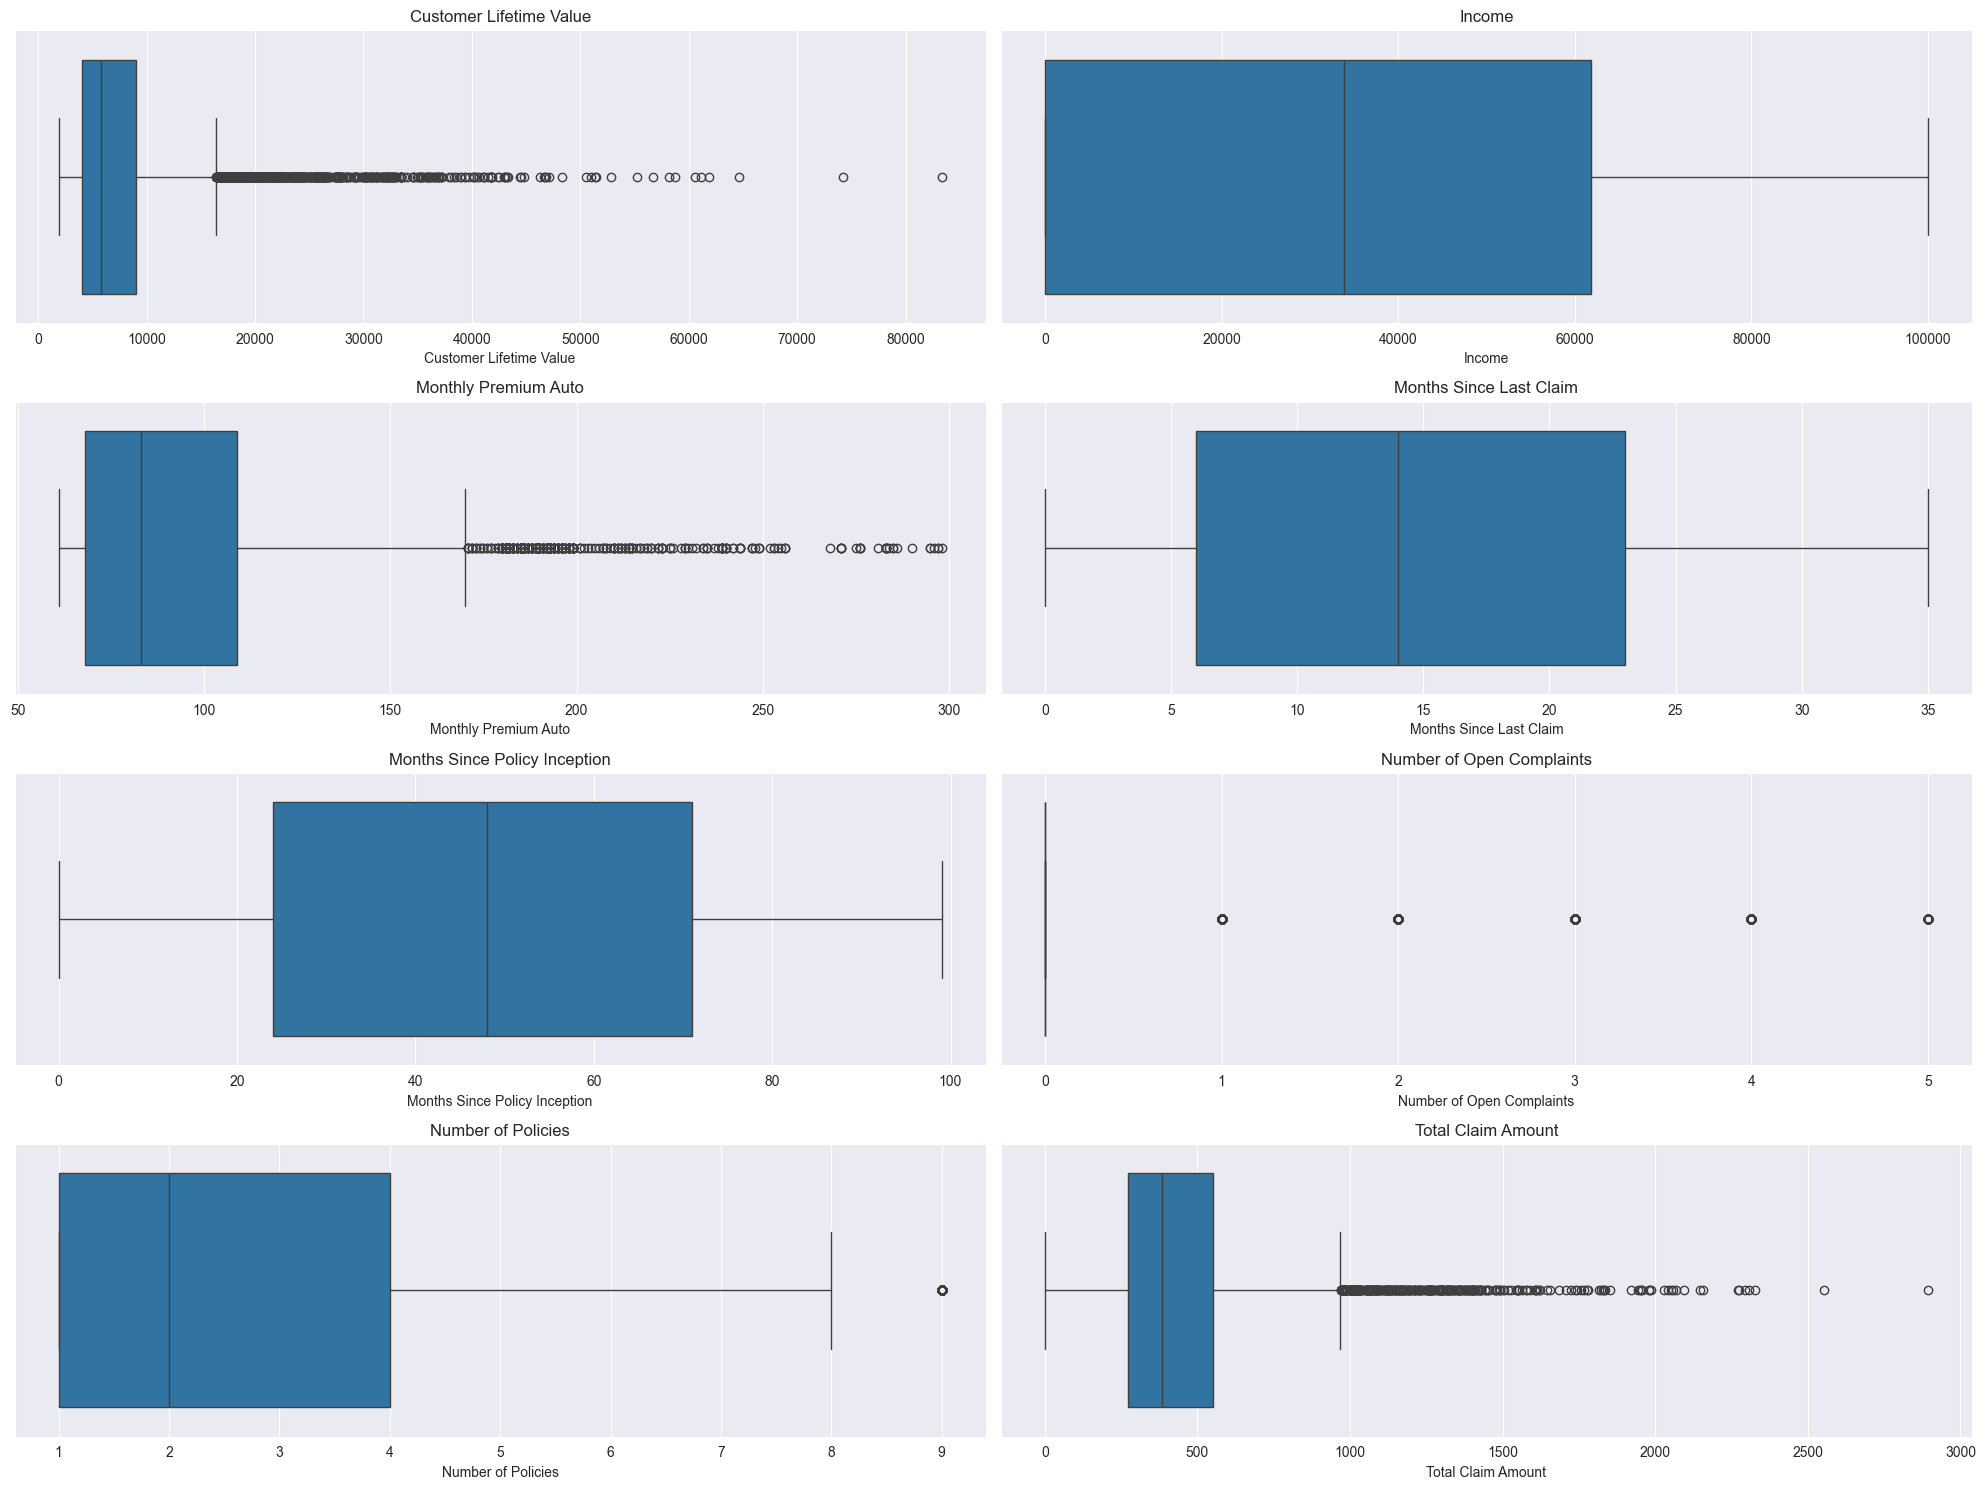

In [24]:
# Outliers
# Present Outliers with Box plot
feature = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies',
       'Total Claim Amount']
plt.figure(figsize=(20, 15))

for idx, col in enumerate(feature, start=1):
    plt.subplot(4, 2, idx)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()

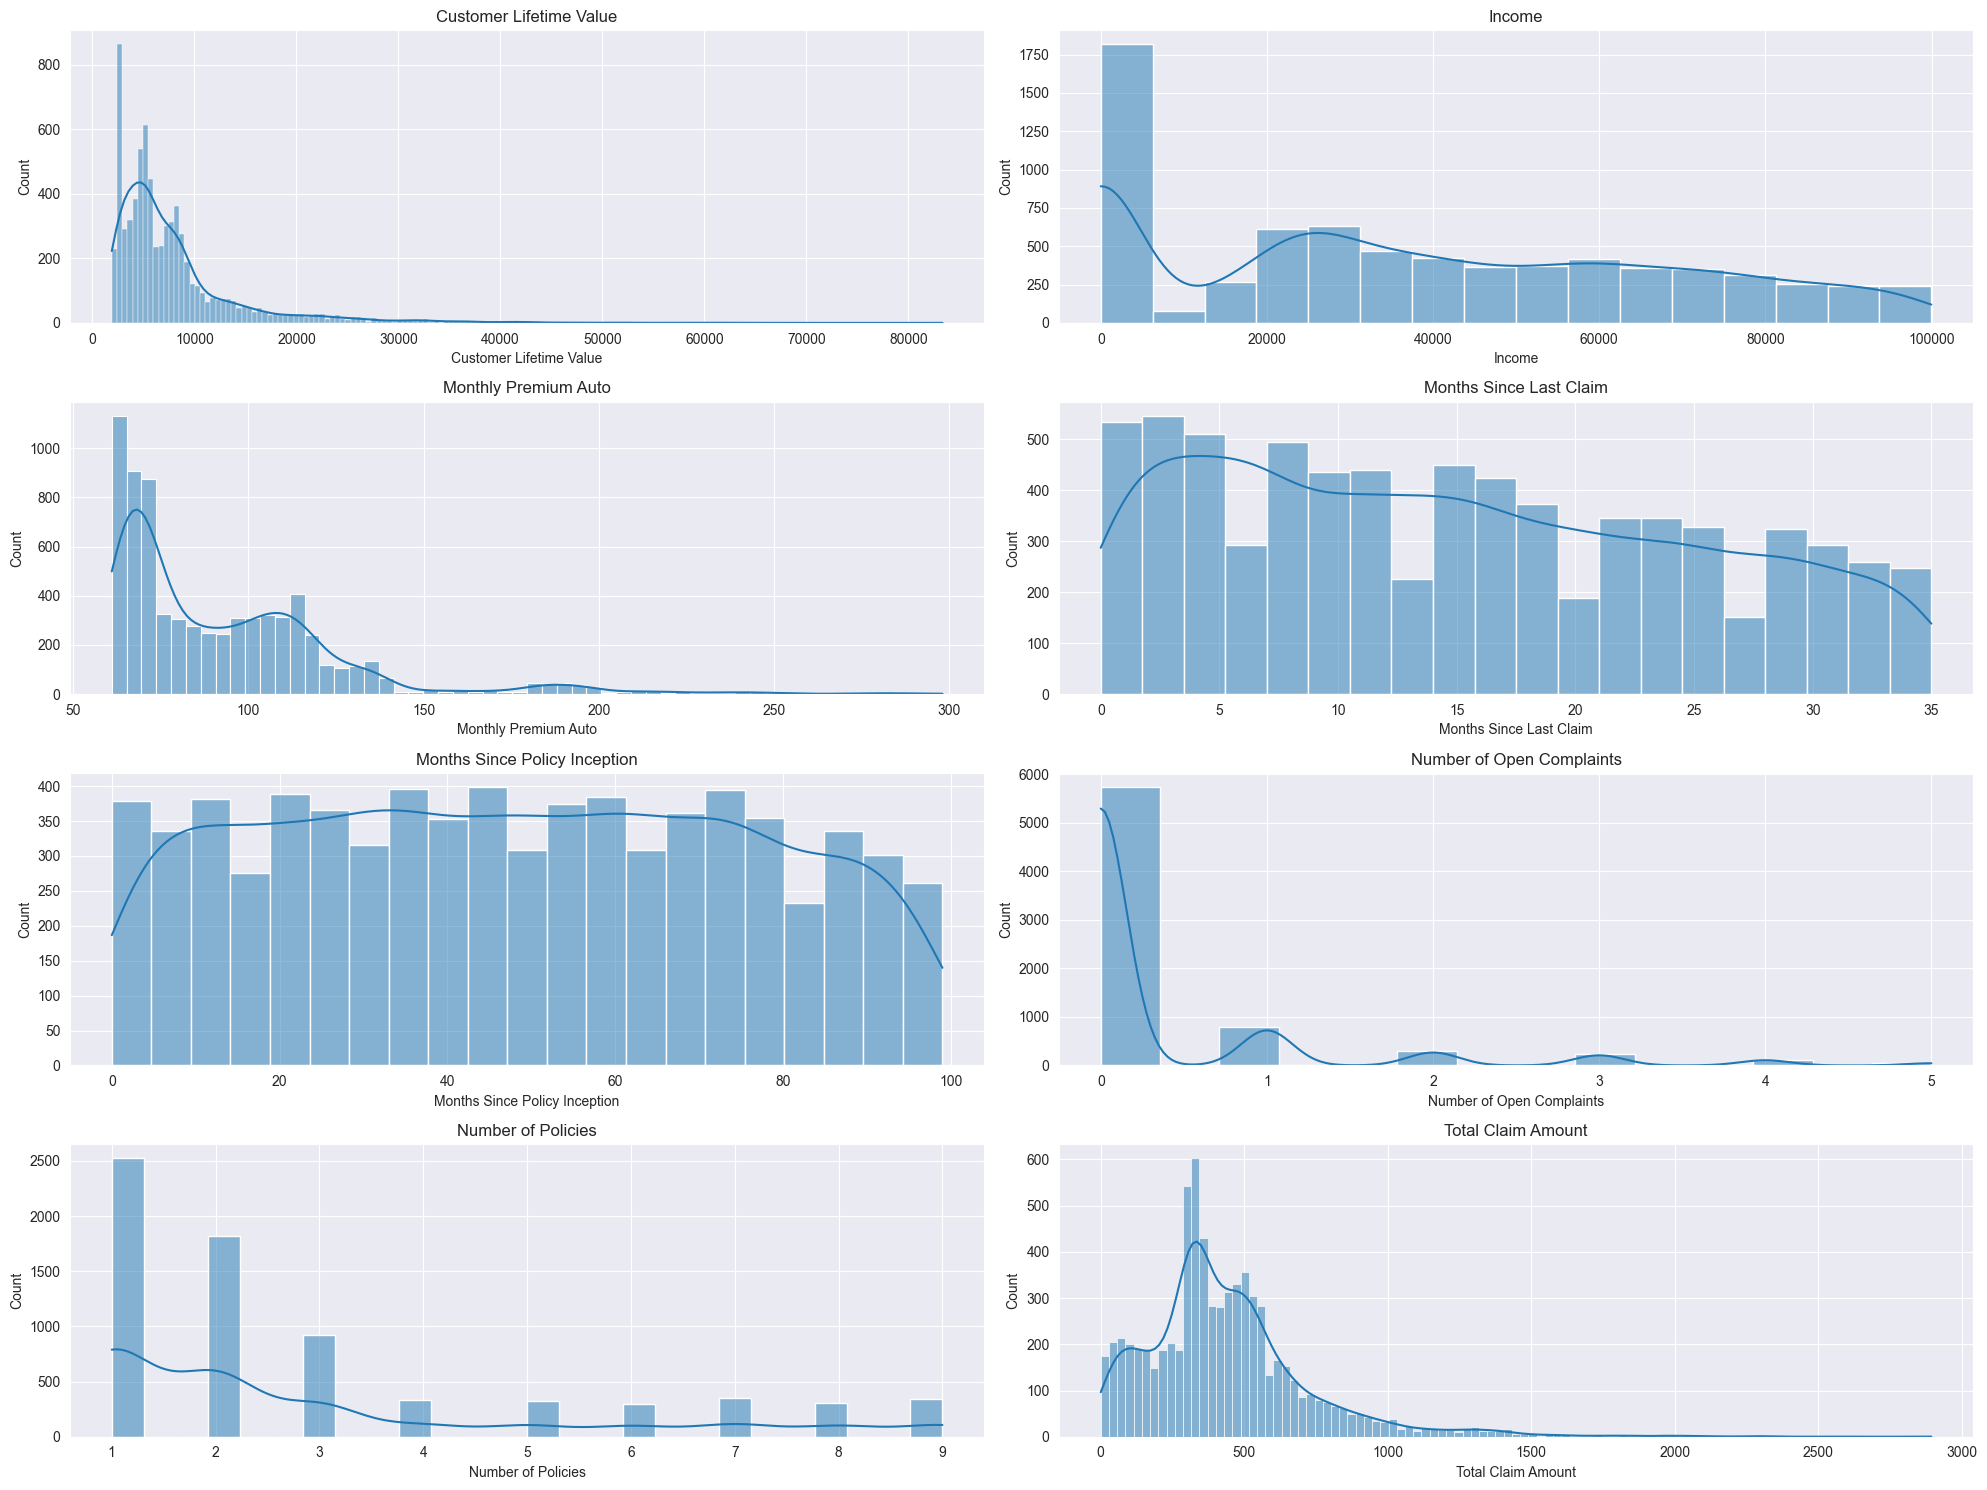

In [25]:
# Outliers
# Present Outliers with Box plot
feature = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies',
       'Total Claim Amount']
plt.figure(figsize=(20, 15))

for idx, col in enumerate(feature, start=1):
    plt.subplot(4, 2, idx)
    sns.histplot(x=df[col],kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

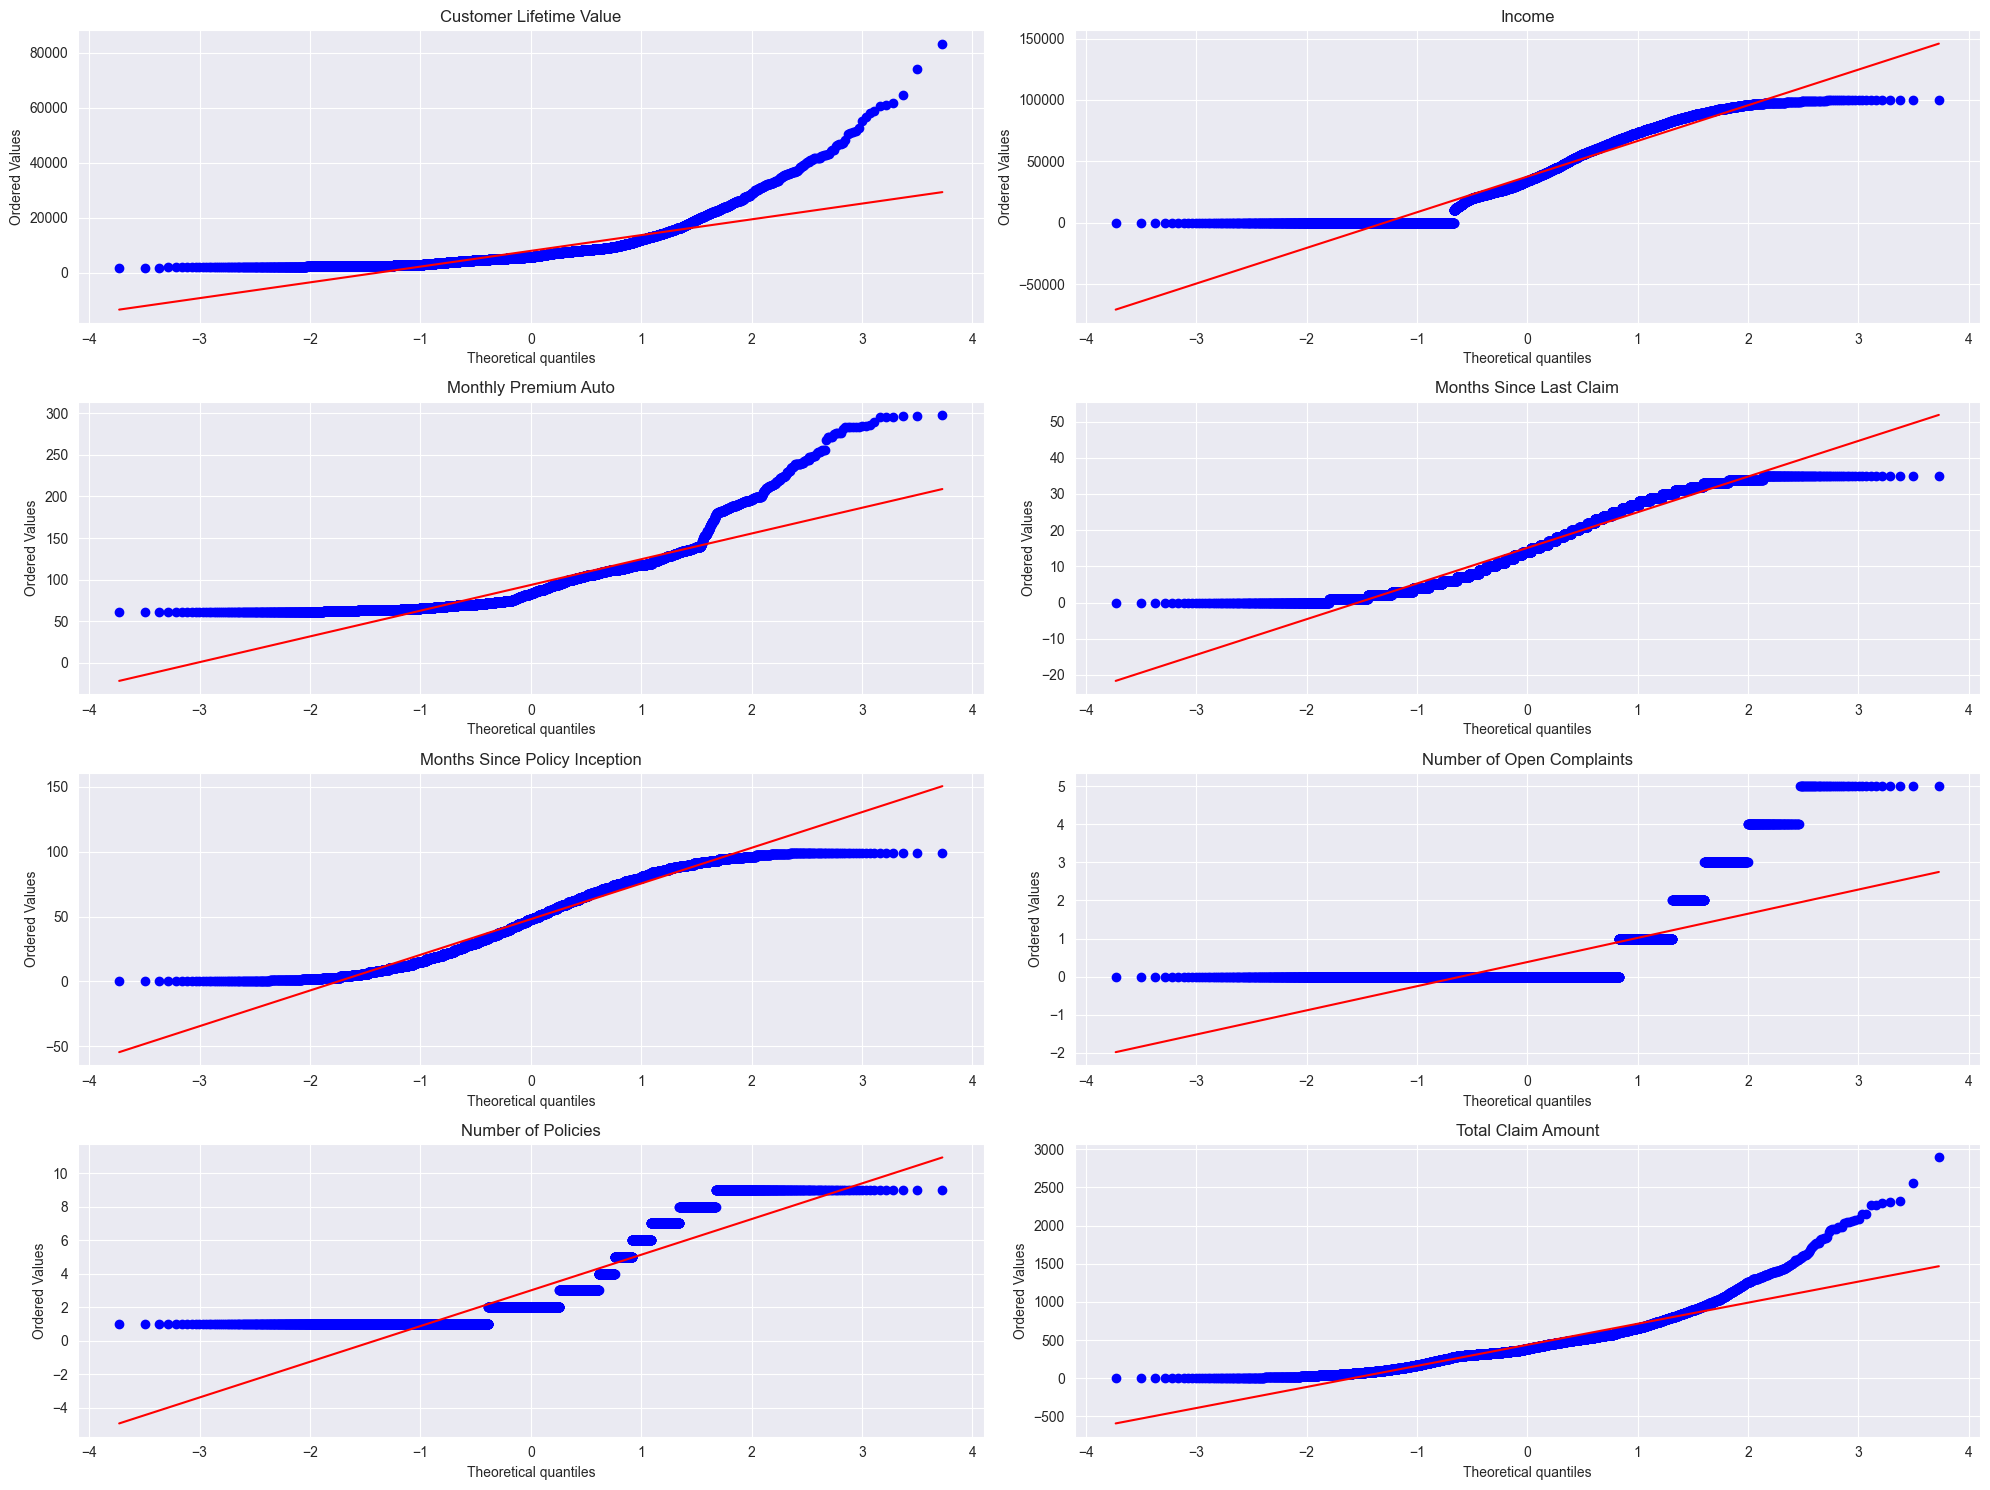

In [26]:
# List of features for which to create Q-Q plots
features = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
            'Months Since Last Claim', 'Months Since Policy Inception',
            'Number of Open Complaints', 'Number of Policies',
            'Total Claim Amount']

# Set up the matplotlib figure
plt.figure(figsize=(20, 15))

# Create a Q-Q plot for each feature
for idx, col in enumerate(features, start=1):
    plt.subplot(4, 2, idx)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(col)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [27]:
# Dictionary to store outliers' information
outliers_info = {}

# Dictionary to count outlier occurrences per row
outlier_counts = {}

# List of columns to check for outliers
columns_to_check = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
                    'Months Since Last Claim', 'Months Since Policy Inception',
                    'Number of Open Complaints', 'Number of Policies',
                    'Total Claim Amount']

for column in columns_to_check:
    # Calculate quartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # Calculate IQR and bounds
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers_condition = (df[column] < lower_bound) | (df[column] > upper_bound)
    outliers = df[outliers_condition]

    # Count outliers
    num_outliers = outliers.shape[0]

    # Calculate percentage of outliers
    total_data_points = df[column].shape[0]
    percentage_outliers = (num_outliers / total_data_points) * 100

    # Store information in the dictionary
    outliers_info[column] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'number_of_outliers': num_outliers,  # Count of outliers
        'percentage_of_outliers': percentage_outliers,  # Percentage of outliers
        'outliers_indices': outliers.index.tolist()  # Indices of outliers
    }

    # Update the outlier counts dictionary
    for idx in outliers.index:
        if idx in outlier_counts:
            outlier_counts[idx] += 1
        else:
            outlier_counts[idx] = 1

# Find rows that are outliers in at least 2 columns
rows_to_drop = [idx for idx, count in outlier_counts.items() if count >= 2]

# Summary for outliers_summary
outliers_summary = {key: {'lower_bound': value['lower_bound'], 
                          'upper_bound': value['upper_bound'],
                          'number_of_outliers': value['number_of_outliers'],
                          'percentage_of_outliers': value['percentage_of_outliers']} 
                    for key, value in outliers_info.items()}

# Create DataFrame from 'outliers_summary'
outliers_summary_df = pd.DataFrame.from_dict(outliers_summary, orient='index')

# Display DataFrame as a styled table with all numerical values formatted to two decimal places
styled_table = outliers_summary_df.style.format({
    'lower_bound': '{:.2f}',
    'upper_bound': '{:.2f}',
    'number_of_outliers': '{}',
    'percentage_of_outliers': '{:.2f}%'
})
display(styled_table)

# Drop rows that are outliers in at least 2 columns
df_cleaned = df.drop(index=rows_to_drop)

# Check the shape of the cleaned DataFrame
print(f"Original DataFrame shape: {df.shape}")



,lower_bound,upper_bound,number_of_outliers,percentage_of_outliers
Customer Lifetime Value,-3310.07,16389.55,643,8.93%
Income,-92782.88,154638.12,0,0.00%
Monthly Premium Auto,6.50,170.50,356,4.94%
Months Since Last Claim,-19.50,48.50,0,0.00%
Months Since Policy Inception,-46.50,141.50,0,0.00%
Number of Open Complaints,0.00,0.00,1464,20.32%
Number of Policies,-3.50,8.50,338,4.69%
Total Claim Amount,-143.18,969.11,368,5.11%


Original DataFrame shape: (7204, 23)


In [28]:
# Dictionary to store outliers' information
outliers_info = {}

# Dictionary to count outlier occurrences per row
outlier_counts = {}

# List of columns to check for outliers
columns_to_check = ['Customer Lifetime Value', 'Income', 'Monthly Premium Auto',
                    'Months Since Last Claim', 'Months Since Policy Inception',
                    'Number of Open Complaints', 'Number of Policies',
                    'Total Claim Amount']

for column in columns_to_check:
    # Calculate quartiles
    Q1 = df_cleaned[column].quantile(0.25)
    Q3 = df_cleaned[column].quantile(0.75)
    
    # Calculate IQR and bounds
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers_condition = (df_cleaned[column] < lower_bound) | (df_cleaned[column] > upper_bound)
    outliers = df_cleaned[outliers_condition]

    # Count outliers
    num_outliers = outliers.shape[0]

    # Calculate percentage of outliers
    total_data_points = df_cleaned[column].shape[0]
    percentage_outliers = (num_outliers / total_data_points) * 100

    # Store information in the dictionary
    outliers_info[column] = {
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'number_of_outliers': num_outliers,  # Count of outliers
        'percentage_of_outliers': percentage_outliers,  # Percentage of outliers
        'outliers_indices': outliers.index.tolist()  # Indices of outliers
    }

    # Update the outlier counts dictionary
    for idx in outliers.index:
        if idx in outlier_counts:
            outlier_counts[idx] += 1
        else:
            outlier_counts[idx] = 1

# Find rows that are outliers in at least 2 columns
rows_to_drop = [idx for idx, count in outlier_counts.items() if count >= 2]

# Summary for outliers_summary
outliers_summary = {key: {'lower_bound': value['lower_bound'], 
                          'upper_bound': value['upper_bound'],
                          'number_of_outliers': value['number_of_outliers'],
                          'percentage_of_outliers': value['percentage_of_outliers']} 
                    for key, value in outliers_info.items()}

# Create DataFrame from 'outliers_summary'
outliers_summary_df = pd.DataFrame.from_dict(outliers_summary, orient='index')

# Display DataFrame as a styled table with all numerical values formatted to two decimal places
styled_table = outliers_summary_df.style.format({
    'lower_bound': '{:.2f}',
    'upper_bound': '{:.2f}',
    'number_of_outliers': '{}',
    'percentage_of_outliers': '{:.2f}%'
})
display(styled_table)

print(f"Cleaned DataFrame shape: {df_cleaned.shape}")



,lower_bound,upper_bound,number_of_outliers,percentage_of_outliers
Customer Lifetime Value,-3126.82,15620.63,455,6.77%
Income,-67322.00,140310.00,0,0.00%
Monthly Premium Auto,11.00,163.00,100,1.49%
Months Since Last Claim,-19.50,48.50,0,0.00%
Months Since Policy Inception,-46.50,141.50,0,0.00%
Number of Open Complaints,0.00,0.00,1202,17.88%
Number of Policies,-3.50,8.50,257,3.82%
Total Claim Amount,-133.59,924.95,165,2.45%


Cleaned DataFrame shape: (6721, 23)


we remove outliers that have more than 1 slice in another column